<a href="https://colab.research.google.com/github/wentao0420/IANNwTF_Group40/blob/main/IANNwTF_week3_Group40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

( train_ds , test_ds ) , ds_info = tfds . load ('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

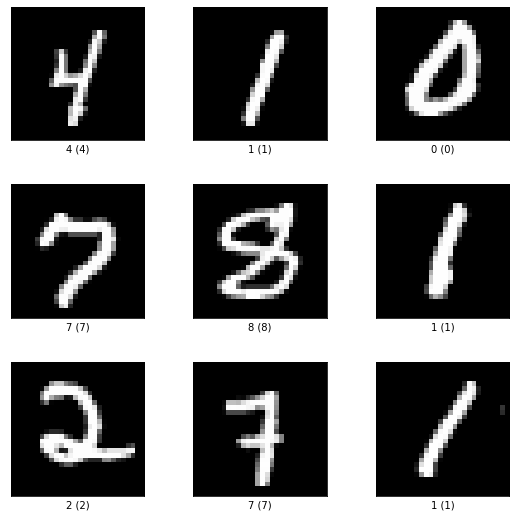

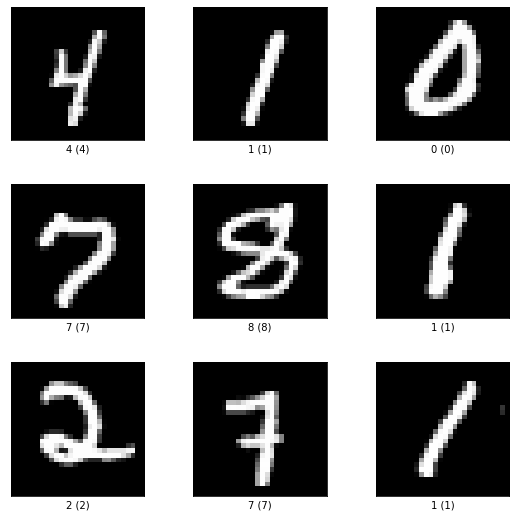

In [ ]:
tfds . show_examples ( train_ds , ds_info )


How many entries are there in the dataset?
What is the format? You must consider questions like these every time you are
designing a network. Answer the following:
* How many training/test images are there?
* What’s the image shape?
* What range are pixel values in?





*   Training images = 60000
*   Test images = 10000

*   Image shape:
  *   Height = 28
  *   Width = 28
  *   Color depth = 1 (indicating the image is black and white)

*   Pixel values are integers from 0 to 255

## **2.2 Setting up the data pipeline**

---


After getting to know the dataset it makes sense to create a data pipeline
function that prepares your data for use in your model. You can use this pipeline
to prepare the training and test data one after another for use in your network.
You can obtain the dataset from the tensorflow-datasets package as showcased in
the lecture. In your pipeline you will need to do a number of things. You may
follow the example code from the lecture again closely here, but let’s summarize
the steps:
The MNIST handwritten digits images come in uint8 datatype. This refers
to unsigned 8-bit integers (think numbers 0-255). As the network requires float
values (think continuous variables) as input rather than integers (whole numbers),
we need to change the datatype: (map in combination with lambda
expressions can be really useful here). In your first lambda mapping you want
to change the datatype from uint8 to tf.float values. To feed your network the
28x28 images also need to be flattened. Check out the reshape function, and if
you want to minimize your work, try and understand how it interacts with size
elements set to the value -1 (infering the remainder shape). In order to improve
the performance you should also normalize your image values. Generally this means bringing the input close to the standart normal (gaussian) distribution
with μ = 0 and σ = 1, however we can make a quick approximation as that:
Knowing the inputs are in the 0-255 interval, we can simply divide all numbers
by 128 (bringing them between 0-2), and finally subtracting one (bringing them
into -1 to 1 range). Additionally you need to encode your labels as one-hot vectors.
Remember a very similar example for the data preparation can be
found in the lecture contents.

In [ ]:
def prepare_mnist_data(mnist):
  #flatten the images into vectors
  mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist = mnist.cache()
  #shuffle, batch, prefetch
  mnist = mnist.shuffle(1000)
  mnist = mnist.batch(32)
  mnist = mnist.prefetch(20)
  #return preprocessed dataset
  return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

# **2.3 Building a deep neural network with TensorFlow**


---


Now that you have your data pipeline built, it is time to create your network.
Check out the courseware for how to go about building a network with Tensor-
Flow’s Keras. Following that method, we want you to build a fully connected
feed-forward neural network to classify MNIST images with. To do this, have a
look at ’Dense’ layers; they basically provide you with the same functionality
as the ’Layer’ class which you have implemented last week. TensorFlow also
provides you with every activation function you might need for this course. A
good (albeit arbitrary) starting point would be to have two hidden layers with
256 units each. For your output layer, think about how many units you need,
and consider which activation function is most appropriate for this task.

In [ ]:
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

# **2.4 Training the network**

---


Define a training loop function which receives

• The number of epochs

• The model object

• The training dataset

• The test dataset

• The loss function

• The optimizer

• Different arrays for the different values you want to track for visualization

It should return the filled arrays after your model is done training. Before you
call the function you will have to define your hyperparameters and initialize
everything. To start off you can use 10 epochs, a learning rate of 0.1, the
categorical cross entropy loss and the optimizer SGD.

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


  tf.keras.backend.clear_session()

#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset = train_dataset.take(1000)
test_dataset = test_dataset.take(100)

### Hyperparameters
num_epochs = 10
learning_rate = 0.001

# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    #training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    #track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    #testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.1190625
Epoch: 1 starting with accuracy 0.8196875
Epoch: 2 starting with accuracy 0.861875
Epoch: 3 starting with accuracy 0.88625
Epoch: 4 starting with accuracy 0.8884375
Epoch: 5 starting with accuracy 0.896875
Epoch: 6 starting with accuracy 0.896875
Epoch: 7 starting with accuracy 0.90375
Epoch: 8 starting with accuracy 0.9059375
Epoch: 9 starting with accuracy 0.90875


# **2.5 Visualization**
---


After traing visualize the performance of your model using matplotlib and the
values that you collected during training and testing. Here is just one example
that you could use.

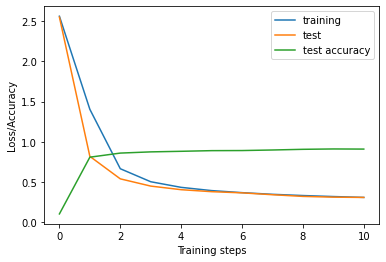

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def visualization ( train_losses , test_losses , test_accuracies ):
  ''' 
  #  Parameters
  #  ---------
  train_losses : np.ndarray 
  train_accuracies : np.ndarray
  test_losses : np.ndarray
  test_accuracies : np.ndarray 
  '''
  plt.figure()
  line1, = plt.plot(train_losses)
  line2, = plt.plot(test_losses)
  line3, = plt.plot(test_accuracies)
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line1,line2, line3),("training","test", "test accuracy"))
  plt.show()


visualization(train_losses, test_losses, test_accuracies)

# Change Hyperparameters:

*   Trial 1 (mnist14) - 
  *   Changing batch size (from 32 to 24) 
  *   Number of epoch (n = 10) and learning rate (eta = 0.001) remained

*   Trial 2 (mnist23) - 
  *   Changing number of epoch (from 10 to 20)
  *   Batch size (n = 32) and learning rate (eta = 0.001) remained

*   Trial 3 (mnist23) - 
  *   Changing learning rate (from 0.001 to 0.1)
  *   Batch size (n = 32) and number of epoch (n = 10) remained

*   Trial 4 (mnist14) - 
  *   Changing batch size (from 32 to 24) 
  *   Changing number of epoch (from 10 to 20)
  *   Changing learning rate (from 0.001 to 0.1)










In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

( train_ds , test_ds ) , ds_info = tfds . load ('mnist', split =[ 'train', 'test'], as_supervised = True , with_info = True )

In [ ]:
# For Trial 1 and 4
def prepare_mnist14_data(mnist14):
  #flatten the images into vectors
  mnist14 = mnist14.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist14 = mnist14.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist14 = mnist14.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist14 = mnist14.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist14 = mnist14.cache()
  #shuffle, batch, prefetch
  mnist14 = mnist14.shuffle(1000)
  mnist14 = mnist14.batch(24)
  mnist14 = mnist14.prefetch(20)
  #return preprocessed dataset
  return mnist14

train_dataset14 = train_ds.apply(prepare_mnist14_data)
test_dataset14 = test_ds.apply(prepare_mnist14_data)

In [ ]:
# For Trial 2 and 3
def prepare_mnist23_data(mnist23):
  #flatten the images into vectors
  mnist23 = mnist23.map(lambda img, target: (tf.reshape(img, (-1,)), target))
  #convert data from uint8 to float32
  mnist23 = mnist23.map(lambda img, target: (tf.cast(img, tf.float32), target))
  #sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
  mnist23 = mnist23.map(lambda img, target: ((img/128.)-1., target))
  #create one-hot targets
  mnist23 = mnist23.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  #cache this progress in memory, as there is no need to redo it; it is deterministic after all
  mnist23 = mnist23.cache()
  #shuffle, batch, prefetch
  mnist23 = mnist23.shuffle(1000)
  mnist23 = mnist23.batch(32)
  mnist23 = mnist23.prefetch(20)  
  #return preprocessed dataset
  return mnist23

train_dataset23 = train_ds.apply(prepare_mnist23_data)
test_dataset23 = test_ds.apply(prepare_mnist23_data)

In [ ]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy


  tf.keras.backend.clear_session()

In [ ]:
#For showcasing we only use a subset of the training and test data (generally use all of the available data!)
train_dataset14 = train_dataset14.take(1000)
test_dataset14 = test_dataset14.take(100)

train_dataset23 = train_dataset23.take(1000)
test_dataset23 = test_dataset23.take(100)

In [ ]:
# Hyperparameters - Number of Epoch changed (from 10 to 20) in Trial 2 and 4
num_epochs13 = 10
num_epochs24 = 20

# Hyperparameters - Learning rate changed (from 0.001 to 0.1) in Trial 3 and 4
learning_rate12 = 0.001
learning_rate34 = 0.1

# Initialize lists for later visualization.
train_losses1 = []
train_losses2 = []
train_losses3 = []
train_losses4 = []

test_losses1 = []
test_losses2 = []
test_losses3 = []
test_losses4 = []

test_accuracies1 = []
test_accuracies2 = []
test_accuracies3 = []
test_accuracies4 = []

In [ ]:
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer12 = tf.keras.optimizers.SGD(learning_rate12)

# Trial 1
test_loss1, test_accuracy1 = test(model, test_dataset14, cross_entropy_loss)
test_losses1.append(test_loss1)
test_accuracies1.append(test_accuracy1)

train_loss1, _ = test(model, train_dataset14, cross_entropy_loss)
train_losses1.append(train_loss1)

for epoch1 in range(num_epochs13):
    print(f'Epoch: {str(epoch1)} starting with accuracy {test_accuracies1[-1]}')

    epoch_loss_agg1 = []
    for input,target in train_dataset14:
        train_loss1 = train_step(model, input, target, cross_entropy_loss, optimizer12)
        epoch_loss_agg1.append(train_loss1)
    
    train_losses1.append(tf.reduce_mean(epoch_loss_agg1))

    test_loss1, test_accuracy1 = test(model, test_dataset14, cross_entropy_loss)
    test_losses1.append(test_loss1)
    test_accuracies1.append(test_accuracy1)

Epoch: 0 starting with accuracy 0.10458333333333332
Epoch: 1 starting with accuracy 0.82375
Epoch: 2 starting with accuracy 0.86625
Epoch: 3 starting with accuracy 0.8758333333333335
Epoch: 4 starting with accuracy 0.8895833333333333
Epoch: 5 starting with accuracy 0.8991666666666669
Epoch: 6 starting with accuracy 0.9025
Epoch: 7 starting with accuracy 0.9129166666666667
Epoch: 8 starting with accuracy 0.9091666666666666
Epoch: 9 starting with accuracy 0.9145833333333334


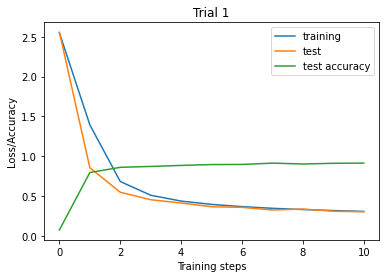

In [ ]:
def visualization ( train_losses1 , test_losses1 , test_accuracies1 ):

  plt.figure()
  line4, = plt.plot(train_losses1)
  line5, = plt.plot(test_losses1)
  line6, = plt.plot(test_accuracies1)
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line4, line5, line6),("training","test", "test accuracy"))
  plt.title("Trial 1")
  plt.show()

visualization(train_losses1, test_losses1, test_accuracies1)

In [ ]:
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer12 = tf.keras.optimizers.SGD(learning_rate12)
optimizer34 = tf.keras.optimizers.SGD(learning_rate34)

# Trial 2
test_loss2, test_accuracy2 = test(model, test_dataset23, cross_entropy_loss)
test_losses2.append(test_loss2)
test_accuracies2.append(test_accuracy2)

train_loss2, _ = test(model, train_dataset23, cross_entropy_loss)
train_losses2.append(train_loss2)

for epoch2 in range(num_epochs24):
    print(f'Epoch: {str(epoch2)} starting with accuracy {test_accuracies2[-1]}')

    epoch_loss_agg2 = []
    for input,target in train_dataset23:
        train_loss2 = train_step(model, input, target, cross_entropy_loss, optimizer12)
        epoch_loss_agg2.append(train_loss2)
    
    train_losses2.append(tf.reduce_mean(epoch_loss_agg2))

    test_loss2, test_accuracy2 = test(model, test_dataset23, cross_entropy_loss)
    test_losses2.append(test_loss2)
    test_accuracies2.append(test_accuracy2)

Epoch: 0 starting with accuracy 0.118125
Epoch: 1 starting with accuracy 0.8115625
Epoch: 2 starting with accuracy 0.8596875
Epoch: 3 starting with accuracy 0.87875
Epoch: 4 starting with accuracy 0.88875
Epoch: 5 starting with accuracy 0.896875
Epoch: 6 starting with accuracy 0.8940625
Epoch: 7 starting with accuracy 0.90125
Epoch: 8 starting with accuracy 0.9028125
Epoch: 9 starting with accuracy 0.91
Epoch: 10 starting with accuracy 0.9103125
Epoch: 11 starting with accuracy 0.9134375
Epoch: 12 starting with accuracy 0.91375
Epoch: 13 starting with accuracy 0.9140625
Epoch: 14 starting with accuracy 0.92
Epoch: 15 starting with accuracy 0.91625
Epoch: 16 starting with accuracy 0.920625
Epoch: 17 starting with accuracy 0.919375
Epoch: 18 starting with accuracy 0.9228125
Epoch: 19 starting with accuracy 0.92125


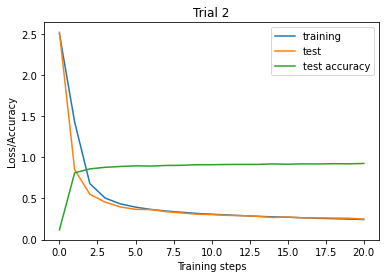

In [ ]:
def visualization ( train_losses2, test_losses2, test_accuracies2 ):

  plt.figure()
  line7, = plt.plot(train_losses2)
  line8, = plt.plot(test_losses2)
  line9, = plt.plot(test_accuracies2)
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line7, line8, line9),("training","test", "test accuracy"))
  plt.title("Trial 2")
  plt.show()

visualization(train_losses2, test_losses2, test_accuracies2)

In [ ]:
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer34 = tf.keras.optimizers.SGD(learning_rate34)

# Trial 3
test_loss3, test_accuracy3 = test(model, test_dataset23, cross_entropy_loss)
test_losses3.append(test_loss3)
test_accuracies3.append(test_accuracy3)

train_loss3, _ = test(model, train_dataset23, cross_entropy_loss)
train_losses3.append(train_loss3)

for epoch3 in range(num_epochs13):
    print(f'Epoch: {str(epoch3)} starting with accuracy {test_accuracies3[-1]}')

    epoch_loss_agg3 = []
    for input,target in train_dataset23:
        train_loss3 = train_step(model, input, target, cross_entropy_loss, optimizer34)
        epoch_loss_agg3.append(train_loss3)
    
    train_losses3.append(tf.reduce_mean(epoch_loss_agg3))

    test_loss3, test_accuracy3 = test(model, test_dataset23, cross_entropy_loss)
    test_losses3.append(test_loss3)
    test_accuracies3.append(test_accuracy3)

Epoch: 0 starting with accuracy 0.0884375
Epoch: 1 starting with accuracy 0.9221875
Epoch: 2 starting with accuracy 0.925
Epoch: 3 starting with accuracy 0.9603125
Epoch: 4 starting with accuracy 0.9596875
Epoch: 5 starting with accuracy 0.9634375
Epoch: 6 starting with accuracy 0.968125
Epoch: 7 starting with accuracy 0.966875
Epoch: 8 starting with accuracy 0.9690625
Epoch: 9 starting with accuracy 0.964375


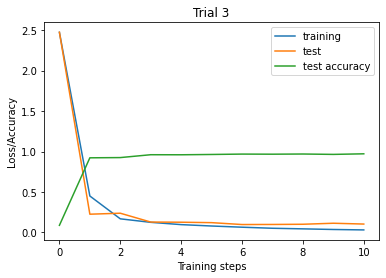

In [ ]:
def visualization ( train_losses3, test_losses3, test_accuracies3 ):

  plt.figure()
  line10, = plt.plot(train_losses3)
  line11, = plt.plot(test_losses3)
  line12, = plt.plot(test_accuracies3)
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line10, line11, line12),("training","test", "test accuracy"))
  plt.title("Trial 3")
  plt.show()

visualization(train_losses3, test_losses3, test_accuracies3)

In [ ]:
# Initialize the model.
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer34 = tf.keras.optimizers.SGD(learning_rate34)

# Trial 4
test_loss4, test_accuracy4 = test(model, test_dataset14, cross_entropy_loss)
test_losses4.append(test_loss4)
test_accuracies4.append(test_accuracy4)

train_loss4, _ = test(model, train_dataset14, cross_entropy_loss)
train_losses4.append(train_loss4)

for epoch4 in range(num_epochs24):
    print(f'Epoch: {str(epoch4)} starting with accuracy {test_accuracies4[-1]}')

    epoch_loss_agg4 = []
    for input,target in train_dataset14:
        train_loss4 = train_step(model, input, target, cross_entropy_loss, optimizer34)
        epoch_loss_agg4.append(train_loss4)
    
    train_losses4.append(tf.reduce_mean(epoch_loss_agg4))

    test_loss4, test_accuracy4 = test(model, test_dataset14, cross_entropy_loss)
    test_losses4.append(test_loss4)
    test_accuracies4.append(test_accuracy4)

Epoch: 0 starting with accuracy 0.10875
Epoch: 1 starting with accuracy 0.9333333333333335
Epoch: 2 starting with accuracy 0.9454166666666666
Epoch: 3 starting with accuracy 0.9441666666666667
Epoch: 4 starting with accuracy 0.9641666666666667
Epoch: 5 starting with accuracy 0.9495833333333334
Epoch: 6 starting with accuracy 0.9604166666666666
Epoch: 7 starting with accuracy 0.9591666666666667
Epoch: 8 starting with accuracy 0.9633333333333334
Epoch: 9 starting with accuracy 0.9654166666666666
Epoch: 10 starting with accuracy 0.9645833333333332
Epoch: 11 starting with accuracy 0.96125
Epoch: 12 starting with accuracy 0.9616666666666666
Epoch: 13 starting with accuracy 0.9541666666666666
Epoch: 14 starting with accuracy 0.96375
Epoch: 15 starting with accuracy 0.9408333333333334
Epoch: 16 starting with accuracy 0.95625
Epoch: 17 starting with accuracy 0.96875
Epoch: 18 starting with accuracy 0.9508333333333333
Epoch: 19 starting with accuracy 0.9654166666666666


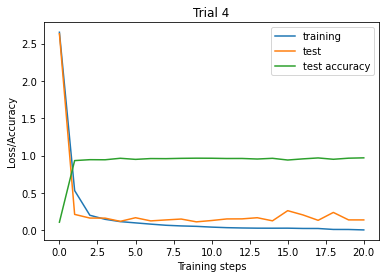

In [ ]:
def visualization ( train_losses4, test_losses4, test_accuracies4 ):

  plt.figure()
  line13, = plt.plot(train_losses4)
  line14, = plt.plot(test_losses4)
  line15, = plt.plot(test_accuracies4)
  plt.xlabel("Training steps")
  plt.ylabel("Loss/Accuracy")
  plt.legend((line13, line14, line15),("training","test", "test accuracy"))
  plt.title("Trial 4")
  plt.show()

visualization(train_losses4, test_losses4, test_accuracies4)

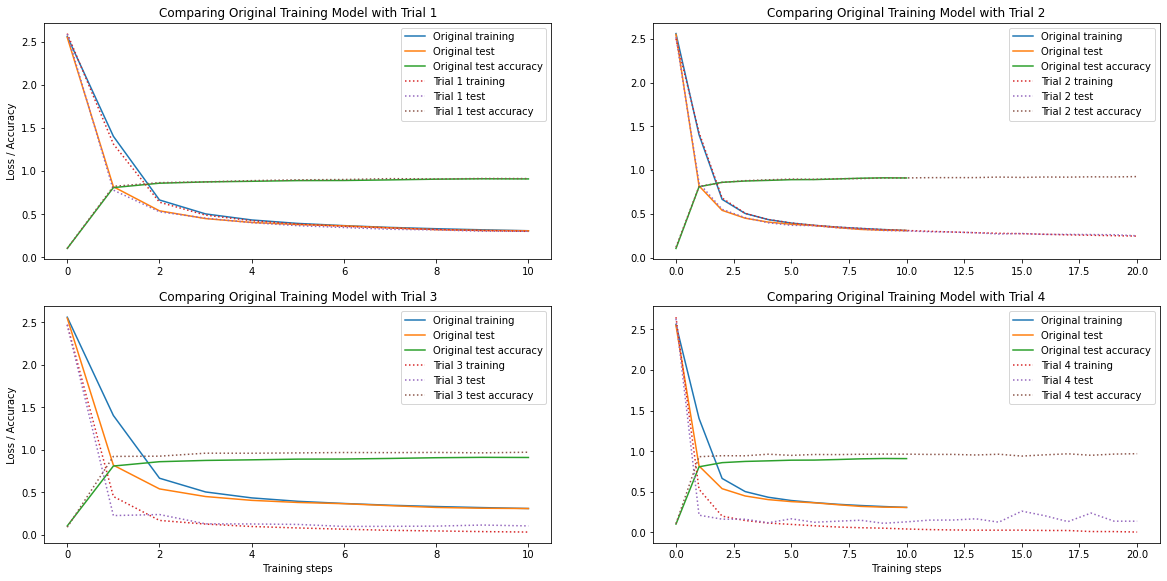

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(421)
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line4, = plt.plot(train_losses1, ls=':')
line5, = plt.plot(test_losses1, ls=':')
line6, = plt.plot(test_accuracies1, ls=':')
plt.legend (( line1, line2, line3, line4, line5, line6 ), 
            ( "Original training","Original test", "Original test accuracy",
            "Trial 1 training", "Trial 1 test", "Trial 1 test accuracy"))
plt.ylabel (" Loss / Accuracy ")
plt.title ("Comparing Original Training Model with Trial 1")

plt.subplot(422)
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line7, = plt.plot(train_losses2, ls=':')
line8, = plt.plot(test_losses2, ls=':')
line9, = plt.plot(test_accuracies2, ls=':')
plt.legend (( line1, line2, line3, line7, line8, line9 ), 
            ( "Original training","Original test", "Original test accuracy",
            "Trial 2 training", "Trial 2 test", "Trial 2 test accuracy"))
plt.title ("Comparing Original Training Model with Trial 2")

plt.subplot(423)
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line10, = plt.plot(train_losses3, ls=':')
line11, = plt.plot(test_losses3, ls=':')
line12, = plt.plot(test_accuracies3, ls=':')
plt.legend (( line1, line2, line3, line10, line11, line12 ), 
            ( "Original training","Original test", "Original test accuracy",
            "Trial 3 training", "Trial 3 test", "Trial 3 test accuracy"))
plt.xlabel (" Training steps ")
plt.ylabel (" Loss / Accuracy ")
plt.title ("Comparing Original Training Model with Trial 3")

plt.subplot(424)
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
line13, = plt.plot(train_losses4, ls=':')
line14, = plt.plot(test_losses4, ls=':')
line15, = plt.plot(test_accuracies4, ls=':')
plt.legend (( line1, line2, line3, line13, line14, line15 ), 
            ( "Original training","Original test", "Original test accuracy",
            "Trial 4 training", "Trial 4 test", "Trial 4 test accuracy"))
plt.xlabel (" Training steps ")
plt.title ("Comparing Original Training Model with Trial 4")

plt.show()

# Observation:

Comparing original training model with each trial model:

*   In Trial 1, decreasing batch size will slightly decrease the accuracy in the beginning, but almost the same at the later part.
*   In Trial 1, decreasing batch size will increase/decrease the loss in the beginning, but almost the same at the later part.
*   In Trial 2, increasing number of epoch will increase/decrease the accuracy
*   In Trial 2, increasing number of epoch will increase/decrease the loss
*   In Trial 3, increasing learning rate will increase the accuracy
*   In Trial 3, increasing learning rate will decrease the loss
*   In Trial 4, combining all the changes, it somehow increases the accuracy
*   In Trial 4, combining all the changes, it somehow decreases the loss





